# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

# DNN Imports
import os
import torch
from tqdm import tqdm
import torch.utils.data
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.preprocessing import StandardScaler

# CFG

# Data Preprocessing

In [2]:
df = pd.read_csv('/kaggle/input/sales-prediction-dataset/car_purchasing.csv', encoding='latin1')

In [3]:
df.head()

,customer name,customer e-mail,country,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,Bulgaria,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,Belize,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,Algeria,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,Cook Islands,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,Brazil,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


In [4]:
df.describe()

,gender,age,annual Salary,credit card debt,net worth,car purchase amount
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.506000,46.241674,62127.239608,9607.645049,431475.713625,44209.799218
std,0.500465,7.978862,11703.378228,3489.187973,173536.756340,10773.178744
min,0.000000,20.000000,20000.000000,100.000000,20000.000000,9000.000000
25%,0.000000,40.949969,54391.977195,7397.515792,299824.195900,37629.896040
50%,1.000000,46.049901,62915.497035,9655.035568,426750.120650,43997.783390
75%,1.000000,51.612263,70117.862005,11798.867487,557324.478725,51254.709517
max,1.000000,70.000000,100000.000000,20000.000000,1000000.000000,80000.000000


## Scatter plot for car purchase amount vs. age

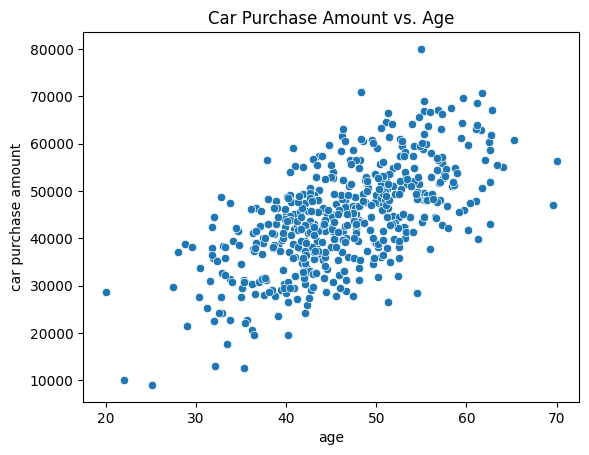

In [5]:
sns.scatterplot(x='age', y='car purchase amount', data=df)
plt.title('Car Purchase Amount vs. Age')
plt.show()

## Boxplot for car purchase amount by gender

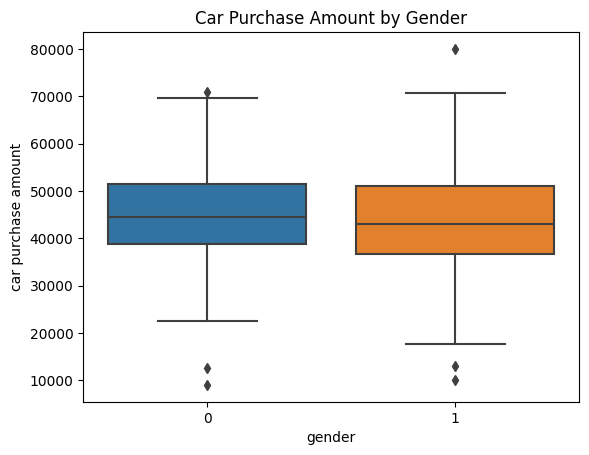

In [6]:
sns.boxplot(x='gender', y='car purchase amount', data=df)
plt.title('Car Purchase Amount by Gender')
plt.show()

## Cross Validation

From previous runs I learned 'credit card debt' doesn't help predictions.

In [7]:
X = df[['age', 'annual Salary', 'net worth']]
y = df['car purchase amount']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Length of X_train:", len(X_train))
print("Length of X_test:", len(X_test))

Length of X_train: 400
Length of X_test: 100


# Training Models

## Randomized Search On Hyper Parameters 

In [9]:
param_dist_rf = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [10, 20, 30, 50, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.5],
    'bootstrap': [True, False],
}

tmp_rf_model = RandomForestRegressor()

param_dist_xgb = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 6, 10, None],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

tmp_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

In [10]:
def perform_random_search(tmp_model, param_dist, n_iter=50, random_state=42):
    
    random_search = RandomizedSearchCV(
        estimator=tmp_model,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=3,
        random_state=random_state,
        n_jobs=-1,
        verbose=0
    )

    # Fit the model to the training data
    random_search.fit(X_train, y_train)

    # Retrieve the best parameters and the best model
    best_params = random_search.best_params_
    model = random_search.best_estimator_

    # Print the best parameters and model name
    print(f"Best {model.__class__.__name__} parameters found:\n{best_params}")

    return model

## Training Ensemble Models

In [11]:
rf_model = perform_random_search(tmp_rf_model, param_dist_rf)
xgb_model = perform_random_search(tmp_xgb_model, param_dist_xgb)

Best RandomForestRegressor parameters found:
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 50, 'bootstrap': True}
Best XGBRegressor parameters found:
{'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.6}


## Training DNN

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
workers = os.cpu_count()
print(device)

cuda


In [13]:
class DNNDataset(Dataset):
    def __init__(self, X, Y, scale_columns=False):
        # Initialize scalers
        self.input_scaler = None
        self.target_scaler = None

        if scale_columns:
            # Scale inputs
            self.input_scaler = StandardScaler()
            scaled_X = self.input_scaler.fit_transform(X)
            self.inputs = torch.tensor(scaled_X, dtype=torch.float32)
            
            # Scale targets
            self.target_scaler = StandardScaler()
            scaled_Y = self.target_scaler.fit_transform(Y.values.reshape(-1, 1))
            self.targets = torch.tensor(scaled_Y, dtype=torch.float32)
        else:
            # Use raw inputs and targets
            self.inputs = torch.tensor(X.values, dtype=torch.float32)
            self.targets = torch.tensor(Y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

    def scale_values(self, values, is_input=True):
        scaler = self.input_scaler if is_input else self.target_scaler
        if scaler:
            return scaler.transform(values)
        return values

    def inverse_transform_values(self, scaled_values, is_input=True):
        scaler = self.input_scaler if is_input else self.target_scaler
        if scaler:
            return scaler.inverse_transform(scaled_values)
        return scaled_values

In [14]:
train_dataset = DNNDataset(X_train, y_train, scale_columns=True)
validation_dataset = DNNDataset(X_test, y_test, scale_columns=True)

In [15]:
# Define batch size
batch_size = 5

val_loader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=workers, pin_memory=True)

In [16]:
# Get the image paths from both datasets
train_inputs = set(train_dataset.inputs)
val_inputs = set(validation_dataset.inputs)

# Check for any common paths
common_data = train_inputs.intersection(val_inputs)

# Print out the results
if common_data:
    print(f"Found {len(common_data)} common data between training and validation datasets:")
    for data in common_data:
        print(data)
else:
    print("No common found between training and validation datasets.")

No common found between training and validation datasets.


In [17]:
def train_and_validate(model, train_dataset, validation_loader, criterion, optimizer, epochs=5, train_loss_threshold=None):
    train_running_loss_history = []
    validation_running_loss_history = []
    lr_history = []
    prev_val_loss = float('inf')
    early_stop = False

    # Calculate the total number of steps in one cycle (total batches across all epochs)
    num_batches = (len(train_dataset) + batch_size - 1) // batch_size
    total_steps = epochs * num_batches
    
    # Define the OneCycleLR scheduler
    init_lr = optimizer.param_groups[0]['lr']
    scheduler = OneCycleLR(optimizer, max_lr=init_lr * 10, total_steps=total_steps)

    # Use tqdm as a context manager for epochs
    with tqdm(total=epochs, desc="Training Progress", leave=True, dynamic_ncols=True) as progress_bar:
        for e in range(epochs):
            train_running_loss = 0.0
            validation_running_loss = 0.0
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
            
            if early_stop:
                break

            model.train()
            # Training loop
            for ith_batch, sample_batched in enumerate(train_loader):
                x_train, y_train = sample_batched[:2]
                X_train = x_train.to(device)
                Y_train = y_train.to(device)

                optimizer.zero_grad()
                y_pred = model(X_train)

                # Calculate losses
                loss = criterion(y_pred, Y_train)

                # Backward and optimize
                loss.backward()
                optimizer.step()

                train_running_loss += loss.item()
                
                # Step the scheduler
                scheduler.step()
                lr_history.append(optimizer.param_groups[0]['lr'])

            # Validation loop
            with torch.no_grad():
                model.eval()
                for ith_batch, sample_batched in enumerate(validation_loader):
                    x_val, y_val = sample_batched[:2]
                    X_val = x_val.to(device)
                    Y_val = y_val.to(device)

                    pred_val = model(X_val)
                    
                    # Calculate losses
                    val_loss = criterion(pred_val, Y_val)
                    
                    validation_running_loss += val_loss.item()

                train_epoch_loss = train_running_loss / len(train_loader)
                validation_epoch_loss = validation_running_loss / len(validation_loader)

                train_running_loss_history.append(train_epoch_loss)
                validation_running_loss_history.append(validation_epoch_loss)
                
                # Update tqdm with train and validation loss for the current epoch
                progress_bar.set_description(f"Epoch {e+1}: Train Loss = {train_epoch_loss:.5f}, Val Loss = {validation_epoch_loss:.5f}")
                progress_bar.update(1)

                if train_loss_threshold is not None:
                    if train_epoch_loss < train_loss_threshold and validation_epoch_loss >= prev_val_loss:
                        progress_bar.set_description(f"Stopping early: Train Loss = {train_epoch_loss:.5f}, Val Loss = {validation_epoch_loss:.5f}")
                        early_stop = True
                    prev_val_loss = validation_epoch_loss

            torch.cuda.empty_cache()

    # Plot loss history
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_running_loss_history, label='Train Loss')
    plt.plot(validation_running_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot learning rate
    plt.subplot(1, 2, 2)
    plt.plot(lr_history, label='Learning Rate')
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [18]:
class SalesDNN(nn.Module):
    def __init__(self, input_size, output_size=1):
        super(SalesDNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

Epoch 25: Train Loss = 0.00003, Val Loss = 0.00109: 100%|██████████| 25/25 [00:11<00:00,  2.16it/s]


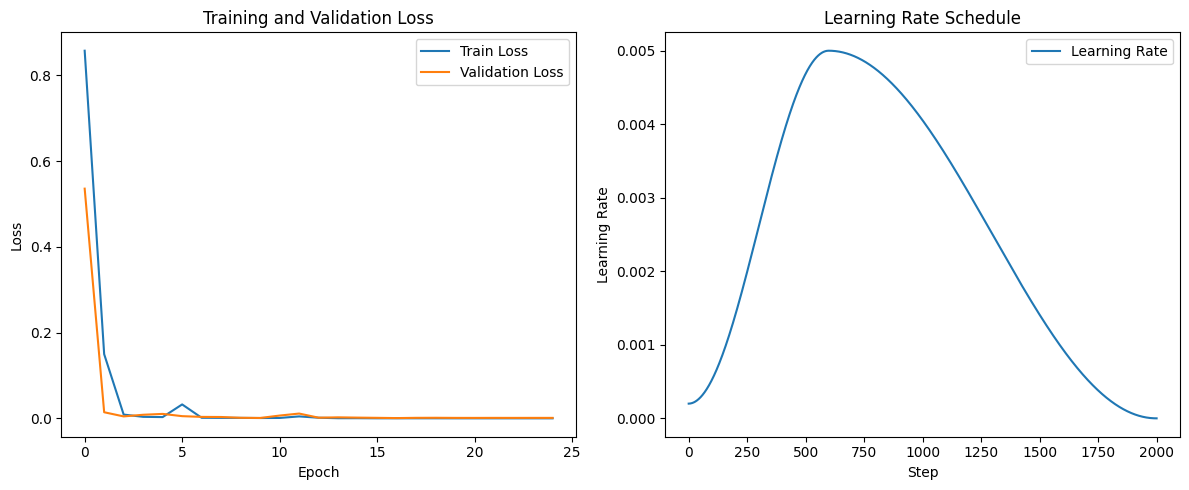

In [19]:
# Define your hyperparameters
epochs = 25
learning_rate = 0.005
weight_decay = 0.0005
input_size = X.shape[1]

# Define loss
criterion = nn.MSELoss()

# Load pre-trained model
dnn_model = SalesDNN(input_size).to(device)

full_opt = optim.AdamW(dnn_model.parameters(), lr=learning_rate/10, weight_decay=weight_decay)

train_and_validate(dnn_model, train_dataset, val_loader, criterion, full_opt, epochs)

# Evaluation

In [31]:
def compare_models(models):
    mae_scores = []
    r2_scores = []

    # Loop through the models, make predictions, and calculate scores
    for model in models:

        if isinstance(model, SalesDNN):
            model.eval()
            all_predictions = []
            all_targets = []
    
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    
                    predictions = model(inputs)
                    
                    # Collect predictions and targets
                    all_predictions.extend(predictions.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())
                    
            # Convert predictions and targets back to the original scale
            all_predictions_original = validation_dataset.inverse_transform_values(
                np.array(all_predictions).reshape(-1, 1), is_input=False)
            all_targets_original = validation_dataset.inverse_transform_values(
                np.array(all_targets).reshape(-1, 1), is_input=False)

            mae = mean_absolute_error(all_targets_original, all_predictions_original)
            r2 = r2_score(all_targets_original, all_predictions_original)
                
        else:
            y_pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
        
        mae_scores.append(mae)
        r2_scores.append(r2)

    # Plot the comparison of MAE and R² scores
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot MAE scores
    ax[0].bar([model.__class__.__name__ for model in models], mae_scores, color='skyblue')
    ax[0].set_title("Mean Absolute Error Comparison")
    ax[0].set_ylabel("Mean Absolute Error")

    # Plot R² scores
    ax[1].bar([model.__class__.__name__ for model in models], r2_scores, color='lightcoral')
    ax[1].set_title("R² Score Comparison")
    ax[1].set_ylabel("R² Score")

    plt.tight_layout()
    plt.show()

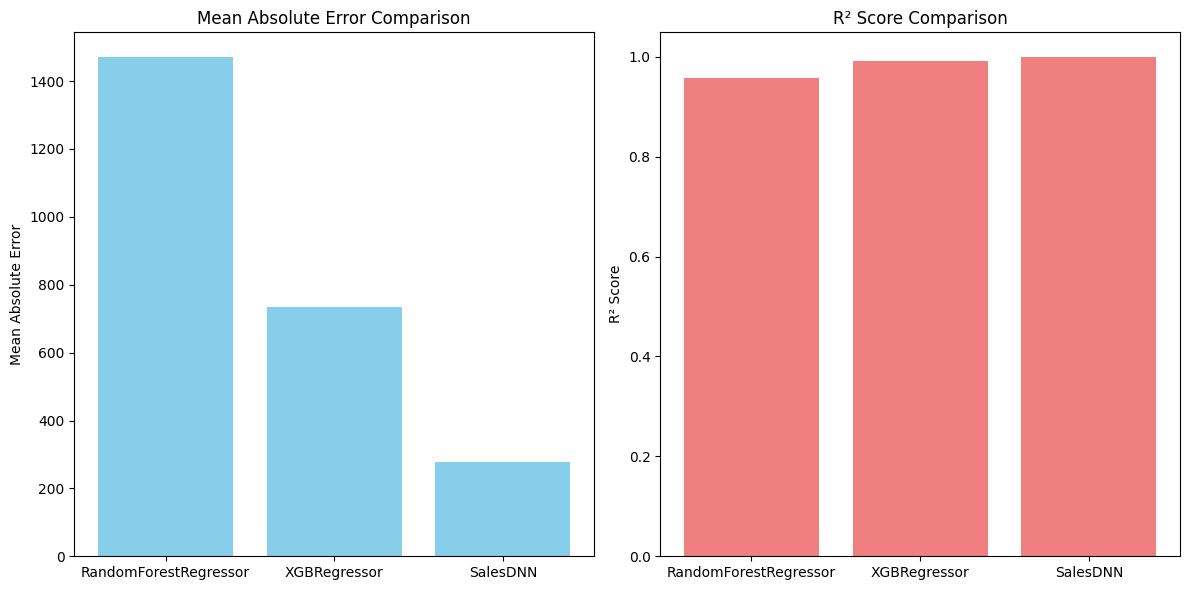

In [32]:
compare_models([rf_model, xgb_model, dnn_model])

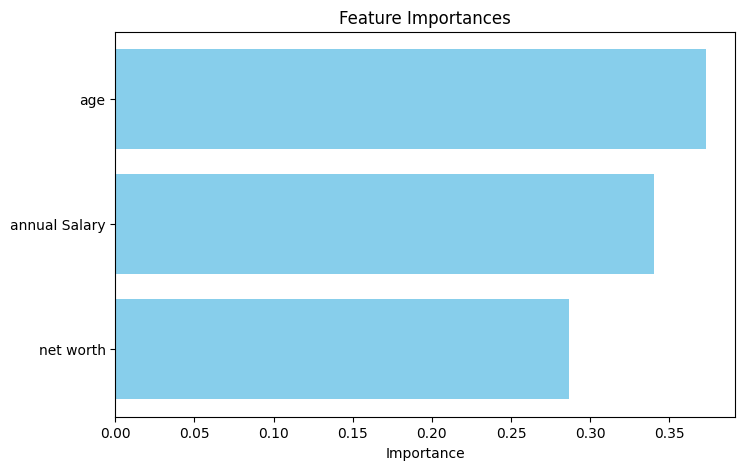

In [26]:
# Get feature names and importances
features = X.columns
importances = xgb_model.feature_importances_

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_features = features[sorted_indices]
sorted_importances = importances[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(8, 5))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()